In [52]:
%matplotlib inline

In [16]:
import torch
import os
from TTS.api import TTS

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

# List available 🐸TTS models
# TTS().list_models().list_tts_models()

models_to_test = [
    'tts_models/multilingual/multi-dataset/xtts_v2', # This require to accept the license from https://coqui.ai/cpml
    # 'tts_models/multilingual/multi-dataset/your_tts', # does not support "es" as language, only ['en', 'fr-fr', 'pt-br']
    'tts_models/multilingual/multi-dataset/bark',
    'tts_models/es/mai/tacotron2-DDC',
    'tts_models/es/css10/vits',
    'tts_models/spa/fairseq/vits'
]

data_folder = '../data/00_test'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(data_folder + '/input'):
    os.makedirs(data_folder + '/input')

if not os.path.exists(data_folder + '/output'):
    os.makedirs(data_folder + '/output')

[**TTS LEADERBOARD**](https://huggingface.co/spaces/TTS-AGI/TTS-Arena)

### Models in Coqui-TTS

- [`multi-dataset/xtts_v2`](https://coqui.ai/blog/tts/open_xtts/): SOTA model for multilingual TTS. For commercial purposes you must buy a license. Model size: ~1.8 GB
- [`multi-dataset/bark`](https://docs.coqui.ai/en/latest/models/bark.html): Multilingual model created by [Suno-AI](https://suno.com/). Model size: ~3.8 GB (Too slow)
- [`mai/tacotron2-DDC`](https://docs.coqui.ai/en/latest/models/tacotron1-2.html): One of the first successful TTS models. Only supports one speaker.
- [`css10/vits`](https://docs.coqui.ai/en/latest/models/vits.html): VITS model for spanish. Only supports one speaker.
- [`fairseq/vits`](https://github.com/facebookresearch/fairseq/blob/main/examples/mms/README.md): Not completely sure, but I think is [`facebook/mms-tts-spa`](https://huggingface.co/facebook/mms-tts-spa) model. Only supports one speaker.
  
### Models that are not in Coqui-TTS
- [`facebook/mmb-1b`](https://huggingface.co/facebook/mms-1b): A massive TTS model by facebook. Only supports one speaker.
- [`facebook/mms-tts-spa`](https://huggingface.co/facebook/mms-tts-spa): Facebook VITS model checkpoint for spanish. Only supports one speaker.
- [`ylacombe/mms-spa-finetuned-chilean-monospeaker`](https://huggingface.co/ylacombe/mms-spa-finetuned-chilean-monospeaker): Finetuned version of `facebook/mms-tts-spa` using [`ylacombe/google-chilean-spanish`](https://huggingface.co/datasets/ylacombe/google-chilean-spanish) dataset. Only supports one speaker.

In [45]:
# speaker_wav comes from https://huggingface.co/datasets/ylacombe/google-chilean-spanish?row=2
speaker_wav = os.path.join(data_folder + '/input', "speaker.wav")
text = "¿Aló, Gonzalo? Buena! cómo estai? acá estamos po, pasándolo terrible bacán"

In [47]:
is_multi_speaker = []

for model in models_to_test:
    print(model)
    model_name = '_'.join(model.split('/')[-2:])
    output_file_path = os.path.join(data_folder + '/output', f"speaker-{model_name}.wav")

    # If fails, possibly the downloaded model is corrupt. You will need no delete the model from ~/.local/share/tts
    tts = TTS(model).to(device)

    if 'bark' in model:
        is_multi_speaker.append(True)
        tts.tts_to_file(text=text, file_path=output_file_path, speaker="input", voice_dir=data_folder)
        continue

    if tts.is_multi_speaker:
        is_multi_speaker.append(True)
        tts.tts_to_file(text=text, language="es", speaker_wav=speaker_wav, file_path=output_file_path)
    else:
        is_multi_speaker.append(False)
        tts.tts_to_file(text=text, file_path=output_file_path)

tts_models/multilingual/multi-dataset/xtts_v2
tts_models/multilingual/multi-dataset/bark


/home/pudu/miniconda3/envs/cachai/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
100%|██████████| 35/35 [00:12<00:00,  2.79it/s]


tts_models/es/mai/tacotron2-DDC


¿alo, ɡonθalo?
Character '¿' not found in the vocabulary. Discarding it.


tts_models/es/css10/vits


¿aló, gonzalo?
Character '¿' not found in the vocabulary. Discarding it.


tts_models/spa/fairseq/vits


¿aló, gonzalo?
Character '¿' not found in the vocabulary. Discarding it.
¿aló, gonzalo?
Character ',' not found in the vocabulary. Discarding it.
¿aló, gonzalo?
Character '?' not found in the vocabulary. Discarding it.
buena! cómo estai?
Character '!' not found in the vocabulary. Discarding it.


In [48]:
from transformers import VitsTokenizer, VitsModel, set_seed
from scipy.io import wavfile

vits_models = ['facebook/mms-tts-spa',
               'ylacombe/mms-spa-finetuned-chilean-monospeaker'
               #'facebook/mms-1b-all' # failed to load via VitsTokenizer
               ]

for vits_model in vits_models:
   print(vits_model)
   set_seed(42)
   model_name = '_'.join(vits_model.split('/')[-2:])

   tokenizer = VitsTokenizer.from_pretrained('facebook/mms-tts-spa')
   model = VitsModel.from_pretrained(vits_model)

   inputs = tokenizer(text=text, return_tensors="pt")
   is_multi_speaker.append(False)

   with torch.no_grad():
      outputs = model(**inputs)

   waveform = outputs.waveform[0]
   output_file_path = os.path.join(data_folder + '/output', f"speaker-{model_name}.wav")
   wavfile.write(output_file_path, rate=model.config.sampling_rate, data=waveform.numpy())

facebook/mms-tts-spa


/home/pudu/miniconda3/envs/cachai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/mms-tts-spa were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.re

ylacombe/mms-spa-finetuned-chilean-monospeaker


Some weights of VitsModel were not initialized from the model checkpoint at ylacombe/mms-spa-finetuned-chilean-monospeaker and are newly initialized: ['flow.flows.0.wavenet.in_layers.0.parametrizations.weight.original0', 'flow.flows.0.wavenet.in_layers.0.parametrizations.weight.original1', 'flow.flows.0.wavenet.in_layers.1.parametrizations.weight.original0', 'flow.flows.0.wavenet.in_layers.1.parametrizations.weight.original1', 'flow.flows.0.wavenet.in_layers.2.parametrizations.weight.original0', 'flow.flows.0.wavenet.in_layers.2.parametrizations.weight.original1', 'flow.flows.0.wavenet.in_layers.3.parametrizations.weight.original0', 'flow.flows.0.wavenet.in_layers.3.parametrizations.weight.original1', 'flow.flows.0.wavenet.res_skip_layers.0.parametrizations.weight.original0', 'flow.flows.0.wavenet.res_skip_layers.0.parametrizations.weight.original1', 'flow.flows.0.wavenet.res_skip_layers.1.parametrizations.weight.original0', 'flow.flows.0.wavenet.res_skip_layers.1.parametrizations.weig

### Text: *¿Aló, Gonzalo? Buena! cómo estai? acá estamos po, pasándolo terrible bacán*

#### Voice reference: `../data/00_test/input/speaker.wav`

#### Model: `multi-dataset_xtts_v2`

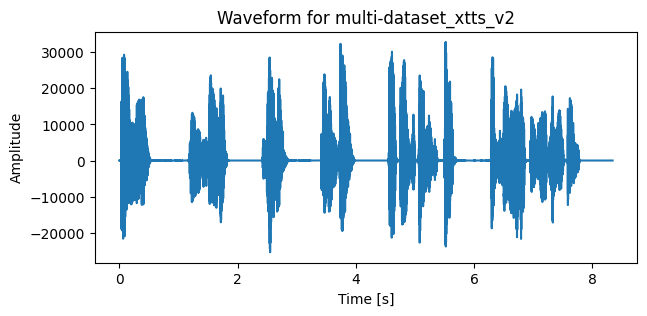

#### Model: `multi-dataset_bark`

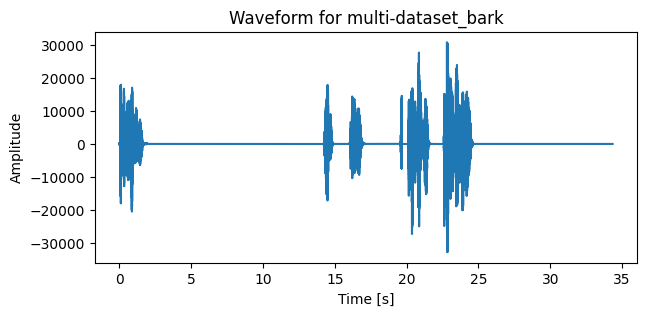

#### Model (no multi speaker): `mai_tacotron2-DDC`

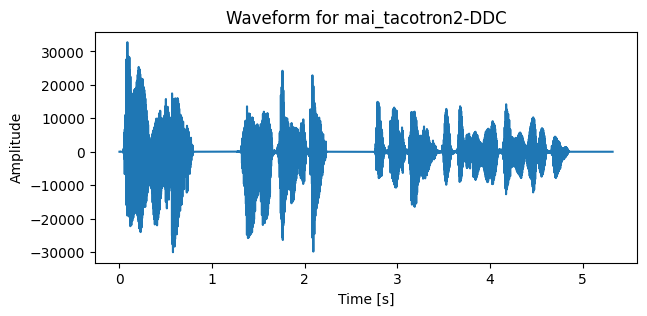

#### Model (no multi speaker): `css10_vits`

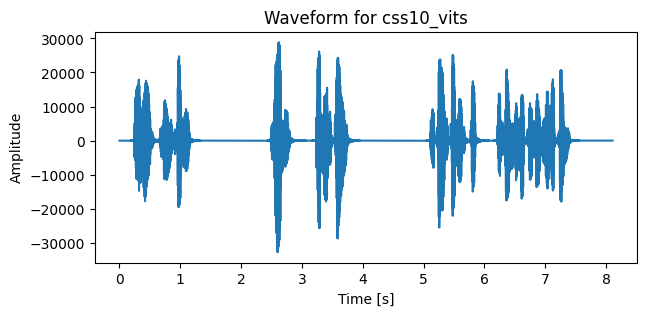

#### Model (no multi speaker): `fairseq_vits`

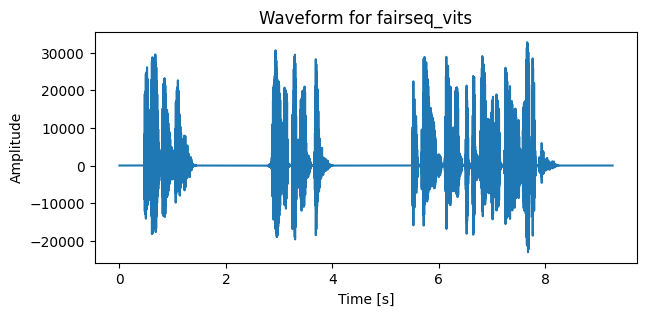

#### Model (no multi speaker): `facebook_mms-tts-spa`

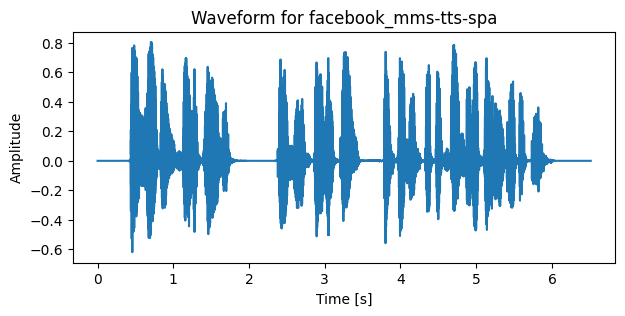

#### Model (no multi speaker): `ylacombe_mms-spa-finetuned-chilean-monospeaker`

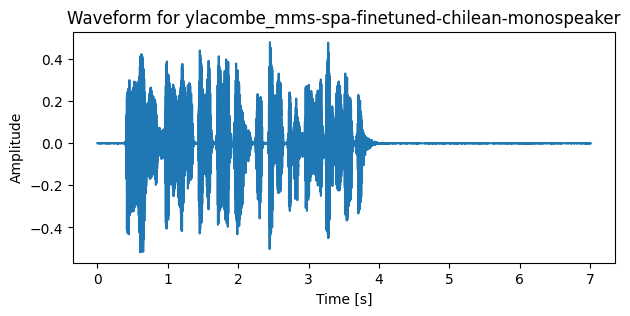

In [54]:
from IPython.display import Audio, Markdown
import matplotlib.pyplot as plt
import numpy as np


def plot_waveform(model, data, sample_rate):
    time = np.linspace(0., len(data) / sample_rate, len(data))
    plt.figure(figsize=(7, 3))
    plt.plot(time, data)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform for {model}")
    plt.show()

original_sample_rate, original_data = wavfile.read(speaker_wav)

# From https://huggingface.co/datasets/ylacombe/google-chilean-spanish?row=2

display(Markdown(f"### Text: *{text}*"))
display(Markdown(f"#### Voice reference: `{speaker_wav}`"))
display(Audio(original_data, rate=original_sample_rate))

for i, model_id in enumerate(models_to_test + vits_models):
    model_name = '_'.join(model_id.split('/')[-2:])

    output_file_path = os.path.join(data_folder + '/output', f"speaker-{model_name}.wav")
    sample_rate, data = wavfile.read(output_file_path)

    multi_speaker = '' if is_multi_speaker[i] else ' (no multi speaker)'
    display(Markdown(f"#### Model{multi_speaker}: `{model_name}`"))
    display(Audio(data, rate=sample_rate))
    plot_waveform(model_name, data, sample_rate)